# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import time
import torch

from collections import deque
from unityagents import UnityEnvironment

from maddpg_agent import Agent

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
def play(random=True):
    
    # Reset the environment
    env_info = env.reset(train_mode=False)[brain_name]
    # Get the current state
    states = env_info.vector_observations
    # Initialize the score to 0
    scores = []
    while True:
        if random:
            # Select a random action for the agent
            actions = np.random.randn(num_agents, action_size) 
            # Clip the actions so that all actions are between -1 and 1
            actions = np.clip(actions, -1, 1)                 
        else:
            # Select an action from making the agent act if random is not True
            actions = get_actions(states, add_noise=False)
        # Send actions to environment
        env_info = env.step(actions)[brain_name]      
        # Get the next states
        next_states = env_info.vector_observations         
        # Get the rewards
        rewards = env_info.rewards                         
        # Check if episode has finished
        dones = env_info.local_done                     
        # Update the scores and the states
        scores, states = scores+env_info.rewards, next_states                        
        # Exit loop if the episode has finished
        if np.any(dones):                                 
            break
    
    return round(np.max(scores), 2)

In [7]:
trials = 5

for trial in range(trials):
    score = play()
    print('Average score for trial {}: {}'.format(trial+1, score))

Average score for trial 1: 0.0
Average score for trial 2: 0.0
Average score for trial 3: 0.0
Average score for trial 4: 0.0
Average score for trial 5: 0.0


In [8]:
# Function to combine the actions of both agents

def get_actions(states, add_noise):
    action_0 = agent_0.act(states, add_noise)
    action_1 = agent_1.act(states, add_noise)
    return np.concatenate((action_0, action_1), axis=0).flatten()

### 4. Train the agents with a neural network

In [9]:
# Some common parameters to use
print_every = 10
add_noise = True

num_states = state_size

To train the agent we use an actor and a critic networks in a Multi-Agent Deep Deterministic Policy Gradient.

Both the actor and critic networks use 2 fully connected layers of depth 256 and 128. Batch normalization is applied to the input of the intermediate layer.

The hyper parameters used are the following:

BUFFER_SIZE = int(1e6)  # replay buffer size

BATCH_SIZE = 128        # minibatch size

LR_ACTOR = 1e-4         # learning rate of the actor

LR_CRITIC = 1e-3        # learning rate of the critic

WEIGHT_DECAY = 0        # L2 weight decay

LEARN_EVERY = 10        # learning timestep interval

LEARN_NUM = 5           # number of learning passes

GAMMA = 0.99            # discount factor

TAU = 3e-2              # for soft update of target parameters

OU_SIGMA = 0.1          # Ornstein-Uhlenbeck noise parameter, volatility

OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion

EPS_START = 5.0         # initial value for epsilon in noise decay process in Agent.act()

EPS_EP_END = 300        # episode to end the noise decay process

EPS_FINAL = 0           # final value for epsilon after decay

In [10]:
def maddpg(n_episodes=1500, max_t=1000, print_every=10):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode

    """
    scores_window = deque(maxlen=100)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    solved = False
    c_states = num_states * 2 # combine states

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = np.reshape(env_info.vector_observations, (1,c_states))
        
        agent_0.reset()
        agent_1.reset()
        
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = np.reshape(env_info.vector_observations, (1,c_states))
            rewards = env_info.rewards
            done = env_info.local_done
            agent_0.step(states, actions, rewards[0], next_states, done, 0)
            agent_1.step(states, actions, rewards[1], next_states, done, 1)
            scores += np.max(rewards)
            states = next_states
            if np.any(done):
                break

        ep_best = np.max(scores)
        scores_window.append(ep_best)
        scores_all.append(ep_best)
        moving_average.append(np.mean(scores_window))
        
        if i_episode % print_every == 0:
            print('\tEpisode {}\tMoving Average: {:.3f}'.format(i_episode, moving_average[-1]))

        if moving_average[-1] >= 0.5: # Reached goal?
            if not solved:
                print('\n\tEnvironment solved in {:d} episodes! \
                \n\tMoving Average: {:.3f} (over past {:d} episodes)\n'.format(
                    i_episode-100, moving_average[-1], 100))
                torch.save(agent_0.actor_local.state_dict(), 'checkpoint_agent_0.pth')
                torch.save(agent_1.critic_local.state_dict(), 'checkpoint_agent_1.pth')
                solved = True
                break
            else:
                continue
            
    return scores_all, moving_average

In [11]:
# Initialize agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

In [12]:
start = time.time()

scores, moving_average = maddpg()

end = time.time()
elapsed = (end - start)
print("Time elapsed: {}min {:.2f}sec.".format(elapsed//60, elapsed%60))

	Episode 10	Moving Average: 0.000
	Episode 20	Moving Average: 0.005
	Episode 30	Moving Average: 0.003
	Episode 40	Moving Average: 0.005
	Episode 50	Moving Average: 0.004
	Episode 60	Moving Average: 0.003
	Episode 70	Moving Average: 0.004
	Episode 80	Moving Average: 0.004
	Episode 90	Moving Average: 0.003
	Episode 100	Moving Average: 0.003
	Episode 110	Moving Average: 0.004
	Episode 120	Moving Average: 0.005
	Episode 130	Moving Average: 0.011
	Episode 140	Moving Average: 0.010
	Episode 150	Moving Average: 0.010
	Episode 160	Moving Average: 0.012
	Episode 170	Moving Average: 0.018
	Episode 180	Moving Average: 0.022
	Episode 190	Moving Average: 0.025
	Episode 200	Moving Average: 0.026
	Episode 210	Moving Average: 0.029
	Episode 220	Moving Average: 0.030
	Episode 230	Moving Average: 0.029
	Episode 240	Moving Average: 0.039
	Episode 250	Moving Average: 0.043
	Episode 260	Moving Average: 0.048
	Episode 270	Moving Average: 0.046
	Episode 280	Moving Average: 0.048
	Episode 290	Moving Average: 

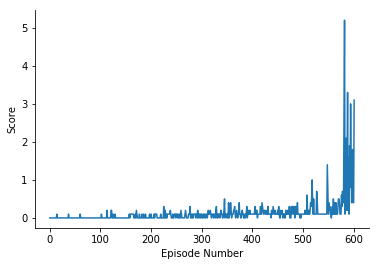

In [13]:
# Plot the scores

fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores, label='DDPG')
ax.set_ylabel('Score')
ax.set_xlabel('Episode Number')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### 5. Future Improvements

To improve the performance of the agents, we could:
1. Fine tune the hyperparameters some more
2. Try more complex MARL architectures

In [ ]:
env.close()